enter the name:cat dog mouse


  0%|          | 0/100 [00:00<?, ?it/s]

Download Complete For cat


  0%|          | 0/100 [00:00<?, ?it/s]

Download Complete For dog


  0%|          | 0/100 [00:00<?, ?it/s]

Download Complete For mouse
Found 140 files belonging to 7 classes.
Using 112 files for training.
Found 140 files belonging to 7 classes.
Using 28 files for validation.
['apple', 'cat', 'dog', 'kiwi', 'mouse', 'orange', 'pineapple']
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 100, 100, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_4 (M

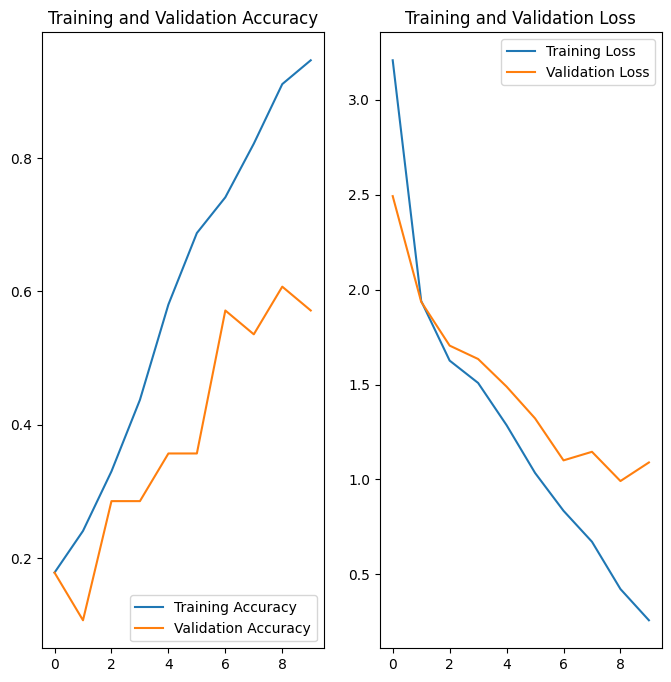

Enter the url of image
1/1 [==============================] - 0s 86ms/step
This image most likely belongs to apple with a 94.19 percent confidence.

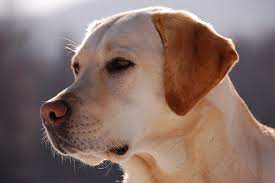

In [2]:
#importing the required Libraries
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen as ureq
import logging
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tqdm.notebook import trange, tqdm
from time import sleep


#creating the directory for our data
save_dir = "images/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"}

#Taking the iput from user
query_input = []
for i in input("enter the name:").split():
  query_input.append(i)

#Scrapping the images from the web
for i in range(0,len(query_input)):

  query = query_input[i]
  response = requests.get(f"https://www.google.com/search?q={query}&client=firefox-b-d&sca_esv=573422471&tbm=isch&source=lnms&sa=X&ved=2ahUKEwjjz_qimvWBAxWX2TgGHb31CdkQ_AUoAnoECAMQBA&biw=1451&bih=684&dpr=1.76")

  soup = BeautifulSoup(response.content, "html.parser")

  image_tag = soup.find_all("img")
  del image_tag[0]
  for i in image_tag:
        image_url = i['src']
        image_data = requests.get(image_url).content
        my_dir = {"index": image_url, "image": image_data}

        #saving the image data in local dictary
        class_name = save_dir+query+"/"
        if not os.path.exists(class_name):
          os.makedirs(class_name)
        with open(os.path.join(class_name, f"{query}{image_tag.index(i)}.jpg"), "wb") as f:
          f.write(image_data)
  for i in tqdm(range(100)):
    sleep(0.05)
    pass
  print(f"Download Complete For {query}")


batch_size = 32
img_height = 200
img_width = 200

#defining the path of our images
data_set = pathlib.Path("/content/images")

#Spliting the data for training with 80%
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_set,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#Spliting the data for validation with 20%
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_set,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


class_names = train_ds.class_names
print(class_names)



AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

test_url = input("Enter the url of image")
test_path = tf.keras.utils.get_file('Red_sunflower', origin=test_url)

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)